<a href="https://colab.research.google.com/github/Spinkk/Implementing-ANNs-with-Tensorflow/blob/main/09/RNN_Minseok.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import time
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


# 1. The task

In my understanding, queries can be variable or fixed over time. Here, I use changing queries for each timepoint. Labels have two binary dimensions, where 0 means less common and 1 means equally or more common. This means (1,0): first query is more common, (0,1): second query is more common, (1,1); both are equally common. The occurence is counted cumulatively, i.e. until the current timepoint.

In [2]:
# we can't give arguments to generator
t = 20  # length of timestep of sequences
batch_size = 32  

def data_gen_batch ():
    """
    Generate a batch of (input, label) pairs. Input is two query and one sequence digits for each timepoint.
    Output indicates which of two queries occur more frequently for each timepoint cumulatively.    
    """

    while True:
        x = np.random.randint(0, 10, (batch_size,t), dtype=np.int32) # actual input sequence
        c1 = np.random.randint(0, 10, (batch_size,t), dtype=np.int32)  # context 1
        c2 = np.random.randint(0, 10, (batch_size,t), dtype=np.int32)  # context 2

        def cumulative_occurence (seq, context):
            occ = np.zeros((batch_size,t))
            # occurence for a slice of sequence until time point i
            for i in range(t):
                # context digit at time i is broadcasted to match dim of seq
                cb = np.repeat(np.array([context[:,i]]).T, i+1, axis=1)
                # count how often digits match for each sample in a batch
                occ[:,i] = np.count_nonzero(seq[:, :i+1] == cb, axis=1)
            return occ
        
        count1 = cumulative_occurence(x,c1)
        count2 = cumulative_occurence(x,c2)
        label = np.array([count1 >= count2, count2 >= count1])  # (1,0): c1>c2, (0,1):c2>c1, (1,1):c1=c2
        label = np.transpose(label, (2,1,0))
        input = tf.concat([tf.one_hot(x,10), tf.one_hot(c1,10), tf.one_hot(c2,10)],-1)
        input = np.transpose(input, (1,0,2))
              
        yield (input,label)  # one-hot encoded then concatanated
        

# create dataset from the generator above with fixed output shapes
ds = tf.data.Dataset.from_generator(generator=data_gen_batch,
                                    output_types=(tf.float32, tf.float32),
                                    output_shapes=((t,batch_size,30), (t,batch_size,2))
                                    )

In [3]:
# example batch dimension
for input,label in ds.take(1):
    print(input.shape)
    print(label.shape)

(20, 32, 30)
(20, 32, 2)


# 2. Model

- The network consists of three layers. Input dense layer, single RNN node and output dense layer.

- We unroll the network using the for loop


d: input dimension, dependent of number of units in read-in layer.

h: hidden dimension, representing the complexity of hidden state. Part of user design.



$[h_{t-1},x_t] = (d+h,1)$

$W_g = (h,d+h)$ with $g = \{f,i,C,o\}$

$b_g = (h,1)$

$g_t = (h,1)$

Typical equation for gate update is
$g_t = \sigma ( W_g \cdot [h_{t-1},x_t]  + b_g)$
where dimensions are

$(h,1) = (h,d+h) (d+h,1) + (h,1)$

In [4]:
class LSTM_cell (tf.keras.layers.Layer):
    def __init__(self, hidden_dim = 100):
        super(LSTM_cell, self).__init__()
        self.h = hidden_dim


    def build(self, input_shape=100):        
        d = input_shape[1]  # 0 is batch size
        h = self.h
        
        # dimension of output vector and weight matrix
        output_shape = (h,)  
        weight_shape = (h+d,h) 
        
        # forget gate
        self.w_f = self.add_weight(shape= weight_shape,
                                   initializer=tf.random_normal_initializer(),
                                   trainable=True)
        
        self.b_f = self.add_weight(shape=output_shape,
                                   # bias of forget gate is initially 1
                                   initializer=tf.keras.initializers.Constant(value=1.0),
                                   trainable=True)
        # input gate
        self.w_i = self.add_weight(shape=weight_shape,
                                   initializer=tf.random_normal_initializer(),
                                   trainable=True)
        
        self.b_i = self.add_weight(shape=output_shape,
                                   initializer=tf.random_normal_initializer(),
                                   trainable=True)
        
        # candidate layer
        self.w_c = self.add_weight(shape=weight_shape,
                                   initializer=tf.random_normal_initializer(),
                                   trainable=True)
        
        self.b_c = self.add_weight(shape=output_shape, 
                                   initializer=tf.random_normal_initializer(),
                                   trainable=True)
        
        # output gate
        self.w_o = self.add_weight(shape=weight_shape,
                                   initializer=tf.random_normal_initializer(),
                                   trainable=True)
        
        self.b_o = self.add_weight(shape=output_shape, 
                                   initializer=tf.random_normal_initializer(),
                                   trainable=True)
        

    def call(self, x_t, h_t, C_t):
        # concatenate previous hidden_state and current input (shape is 20,1)
        concat = tf.concat([h_t, x_t], axis=1) # across axis with size 30 for input!
        # calculate f_t (the forget gate)
        f_t = tf.nn.sigmoid( tf.linalg.matmul(concat,self.w_f) + self.b_f )                                                                              
        # calculate the input gate i_t
        i_t = tf.nn.sigmoid( tf.linalg.matmul(concat,self.w_i) + self.b_i )
        # calculate the Cell state candidates (C_hat)
        C_hat_t = tf.nn.tanh( tf.linalg.matmul(concat,self.w_c) + self.b_c )
        # calculate the Cell state (C_t)
        C_t = f_t * C_t + i_t * C_hat_t
        # calculate the output state (o_t)
        o_t = tf.nn.sigmoid(tf.linalg.matmul(concat,self.w_o) + self.b_o )
        # calculate the new hidden state (h_t)
        h_t = o_t * tf.nn.tanh(C_t)
        
        return h_t, C_t

In [5]:
# example of one forward computation of LSTM cell
cell = LSTM_cell(hidden_dim=4)
cell(tf.constant([[1.0, 2, 3]]), tf.constant([[1, 1, 1.0, 1]]), tf.constant([[0.0]]))


(<tf.Tensor: shape=(1, 4), dtype=float32, numpy=
 array([[ 0.06850173, -0.0198581 ,  0.0546665 ,  0.06519223]],
       dtype=float32)>, <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
 array([[ 0.16173248, -0.04295301,  0.12119889,  0.15963387]],
       dtype=float32)>)

In [6]:
class LSTM_net (tf.keras.Model):
    '''
    Build a LSTM net with a single recurrent node
    '''
    def __init__(self, hidden_dim=100, readin_dim=100):
        super(LSTM_net, self).__init__()
        self.h = hidden_dim
        self.readin = tf.keras.layers.Dense(readin_dim)
        self.recurrent = LSTM_cell(hidden_dim = self.h)
        self.readout = tf.keras.layers.Dense(2, activation = "sigmoid")
        
        
    def call(self, x):            
        # reset hidden and cell state to an inital state
        # (batch_size, h) to have different states for each sample
        self.hidden_state = tf.zeros((x.shape[1], self.h))
        self.cell_state = tf.ones((x.shape[1], self.h))
        # tensorarray to save output sequences of the network
        self.outputs = tf.TensorArray(dtype = tf.float32, size=0, dynamic_size=True)
        # unrolling network by iterative forward computation
        for i in tf.range(x.shape[0]):  # x has dimension of (time, batch, 30)
            digit = self.readin(x[i])  # x at time i
            # update h_t and C_t to save externally
            self.hidden_state, self.cell_state = self.recurrent(digit, self.hidden_state, self.cell_state)
            digit = self.readout(self.hidden_state)
            # save output for time i
            self.outputs = self.outputs.write(i, # expand dim to concat later
                                              tf.expand_dims(digit, axis=0)) 
        self.outputs = self.outputs.concat()  
        return self.outputs

In [7]:
# example of forward computation
lstm = LSTM_net()
for x,target in ds.take(1):
    res = lstm(x)
res.shape

TensorShape([20, 32, 2])

# 3. Training

## Regression vs Classification

We chose to model the task as a classification task because the answer our model is supposed to give is discrete (binary choices and not a continous variable that needs to be predicted). We chose Categorical Crossentropy because we have two sigmoid outputs (1 if the count for the first context number is greater equal the count for the second context number and 0 if it's smaller)

## Truncated Backpropagation Through Time?

Since we only have a sequence length of 20, truncation will not be necessary. The unrolled network is not too deep so we don't have major issues with vanishing gradients.+

In [8]:
class Timer():
    """
    A small class for making timings.
    """
    def __init__(self):
        self._start_time = None

    def start(self):
        """
        Start a new timer
        """
        if self._start_time is not None:
            raise TimerError(f"Timer is running. Use .stop() to stop it")

        self._start_time = time.perf_counter()

    def stop(self):
        """
        Stop the timer, and report the elapsed time
        """
        if self._start_time is None:
            print(f"Timer is not running. Use .start() to start it")
            return 0
    
        elapsed_time = time.perf_counter() - self._start_time
        self._start_time = None
        return elapsed_time

In [9]:
@tf.function
def train_step(model, ds, loss_function, optimizer, train_loss_metric, train_acc_metric):
    '''
    Training for one epoch.
    '''

    for seq, target in ds.take(100): # use 100 batch per epoch
        # forward pass with GradientTape
        with tf.GradientTape() as tape:
            prediction = model(seq)
            loss = loss_function(target, prediction)

        # backward pass via GradienTape (auto-gradient calc)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        # update metrics
        train_loss_metric.update_state(loss)
        train_acc_metric.update_state(target, prediction)

In [10]:
# hyperparams
epochs = 20
learning_rate = 0.0005
batch_size = 32

tf.keras.backend.clear_session()
timer = Timer()

model = LSTM_net()

loss_function = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate)

# prepare metrics
train_acc_metric = tf.keras.metrics.CategoricalAccuracy('train_accuracy')
train_loss_metric = tf.keras.metrics.Mean('train_loss')

# Initialize lists for later visualization.
train_losses = []
train_accuracies = []
times = []

In [11]:
print(f'[INFO] - Started training of the {model.name}.')

for epoch in range(epochs):
    print(f'\n[EPOCH] ____________________{epoch}____________________')
    
    # training step with metrics update--------------------------------------------------------
    timer.start()

    train_step(model, ds,loss_function, optimizer, train_loss_metric, train_acc_metric)

    # Evaluating training metrics
    train_loss = train_loss_metric.result()
    train_acc = train_acc_metric.result()
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    train_acc_metric.reset_states()
    train_loss_metric.reset_states()
    
    elapsed_time = timer.stop()
    times.append(elapsed_time)
    
    print(f'[{epoch}] - Finished Epoch in {elapsed_time:0.2f} seconds - train_loss: {train_loss:0.4f}, train_acc: {train_acc:0.4f}')
  
    if epoch%3 == 0:
        print(f'\n[INFO] - Total time elapsed: {np.sum(times)/60:0.4f} min. Total time remaining: {(np.sum(times)/(epoch+1))*(epochs-epoch-1)/60:0.4f} min.')

print(f'[INFO] - Total run time: {np.sum(times)/60:0.4f} min.')

[INFO] - Started training of the lstm_net.

[EPOCH] ____________________0____________________
Timer is not running. Use .start() to start it
[0] - Finished Epoch in 0.00 seconds - train_loss: 0.9807, train_acc: 0.4732

[INFO] - Total time elapsed: 0.0000 min. Total time remaining: 0.0000 min.

[EPOCH] ____________________1____________________
Timer is not running. Use .start() to start it
[1] - Finished Epoch in 0.00 seconds - train_loss: 0.9811, train_acc: 0.5227

[EPOCH] ____________________2____________________
Timer is not running. Use .start() to start it
[2] - Finished Epoch in 0.00 seconds - train_loss: 0.9696, train_acc: 0.5641

[EPOCH] ____________________3____________________
Timer is not running. Use .start() to start it
[3] - Finished Epoch in 0.00 seconds - train_loss: 0.9233, train_acc: 0.6510

[INFO] - Total time elapsed: 0.0000 min. Total time remaining: 0.0000 min.

[EPOCH] ____________________4____________________
Timer is not running. Use .start() to start it
[4] - F

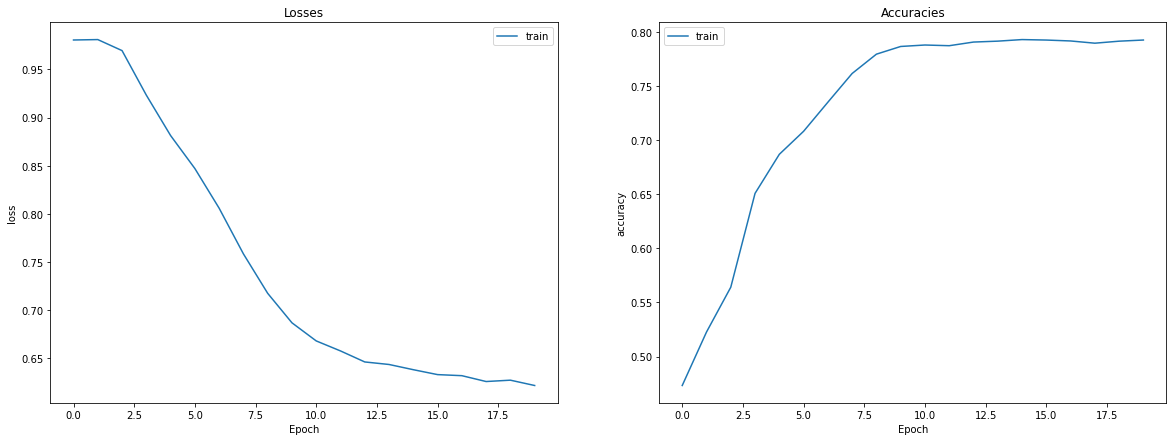

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))

x = np.arange(len(train_losses))

# losses
axes[0].plot(x, train_losses, label='train')
# axes[0].plot(x, test_losses, label='test')
axes[0].legend()
axes[0].set(title='Losses', xlabel='Epoch', ylabel='loss')

# accuracies
axes[1].plot(x, train_accuracies, label='train')
# axes[1].plot(x, test_accuracies, label='test')
axes[1].legend()
axes[1].set(title='Accuracies', xlabel='Epoch', ylabel='accuracy')

plt.show()

